Load all png(Lab Prescription) files:


In [1]:
import os
import cv2

input_folder = r"C:\Users\gayat\Desktop\project\data"

#List to store image data and filenames
images = []

# Loop through all PNG files in the folder
for file_name in os.listdir(input_folder):
    if file_name.lower().endswith(".png"):
        file_path = os.path.join(input_folder, file_name)
        img = cv2.imread(file_path)  # Load image
        images.append((file_name, img))



Convert Image to text: (Set the path to your Tesseract executable)



In [2]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"



Loop through images and run OCR using Threadpool Executor:



In [3]:
# Faster OCR using multiprocessing
import concurrent.futures
ocr_texts = []


def ocr_image(image_tuple):
    file_name, img = image_tuple
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img_rgb)
    return {"File": file_name, "Text": text}

# Run OCR in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    ocr_texts = list(executor.map(ocr_image, images))



Display OCR result

In [4]:
print("Filename:", ocr_texts[0]['File'])
print("Extracted Text:\n", ocr_texts[0]['Text'])

Filename: 0.png
Extracted Text:
 LABORATORY REPORT

Patient Name: Vicki Frank Age: 53

DOB: 1971-06-26 Gender: female

Address: 711 Cole Stravenue Suite 23 City: Franklin

State: MA Country: US

PostalCode: 02038 MaritalStatus: | Married

MRN: a698a486-824d-3beb-5d74-cd7809889e2b Report Date: Dec 13, 2014, 01:54:26

Test Result Units

Body Height 179.9 cm
Pain severity - 0-10 verbal numeric rating [Score] 1.0 {score}
- Reported
Body Weight 98.5 kg
Body mass index (BMI) [Ratio] 30.44 kg/m2
Diastolic Blood Pressure 86 mm[Hg]
Systolic Blood Pressure 100 mm[Hg]
Heart rate 96.0 /min
Respiratory rate 14.0 /min
Generalized anxiety disorder 7 item (GAD-7) total 3.0 {score}
score [Reported.PHQ]
Patient Health Questionnaire 2 item (PHQ-2) total 2.0 {score}
score [Reported]
Total score [AUDIT-C] 1.0 {score}

Dr. Wynell Mayert

[m] 1 = [=] Booking Centre:- WELLNESS ON WHEELS,PC

=_ © (263)761-9191 B robin83@example.com ® http://fisher.com/

[mu] All Lab results are subject to clinical interpretati

Extract structured information using regex

In [5]:
import re

patterns = {
    "Patient Name": r"Patient Name[:\s]*(.*?)\s+Age:",

    "DOB": r"DOB[:\s]*(\d{4}-\d{2}-\d{2})",
    "Age": r"Age[:\s]*(\d+)",
    "Gender": r"Gender[:\s]*(\w+)",
    "Body Height": r"Body Height[:\s]*(\d+\.?\d*)\s*cm",
    "Body Weight": r"Body Weight[:\s]*(\d+\.?\d*)\s*kg",
    "BMI": r"Body mass index \(BMI\)\s*\[.*\]\s*(\d+\.?\d*)",
    "Systolic BP": r"Systolic Blood Pressure[:\s]*(\d+)",
    "Diastolic BP": r"Diastolic Blood Pressure[:\s]*(\d+)",
    "Heart Rate": r"Heart rate[:\s]*(\d+\.?\d*)",
    "Respiratory Rate": r"Respiratory rate[:\s]*(\d+\.?\d*)",
    "Doctor": r"Dr\.?\s+([A-Za-z\s]+)"
}


Clean patient names: Remove unwanted characters


In [6]:
import re

text = "Patient Name: — Leonia Roxie Age: 53"

# Capture everything before Age:
match = re.search(r"Patient Name[:\s]*(.*?)\s+Age:", text)
if match:
    name = match.group(1)
    # Remove unwanted leading/trailing characters (dashes, bullets, spaces)
    name = name.strip(" -–—·")   # note: em dash is included
    # Normalize whitespace
    name = " ".join(name.split())
    print(name)  # Output: Leonia Roxie


Leonia Roxie


Apply regex to all OCR results

In [7]:
structured_data = []

for record in ocr_texts:
    file_name = record['File']
    text = record['Text']
    
    extracted = {"File": file_name}
    
    for key, pattern in patterns.items():
        match = re.search(pattern, text)
        if match:
            value = match.group(1).strip()
        # Clean Patient Name for InvoiceNet
            if key == "Patient Name":
            # Remove leading/trailing non-letter characters (dashes, bullets, spaces)
                value = re.sub(r"^[^A-Za-z]+", "", value)   # remove leading unwanted chars
                value = re.sub(r"[^A-Za-z\s]+$", "", value) # remove trailing unwanted chars
                value = " ".join(value.split())             # normalize whitespace
            extracted[key] = value
        else:
            extracted[key] = ""

    
    structured_data.append(extracted)

#Output list of dictonaries each representing one image with extracted fields.

In [8]:
import pandas as pd

df = pd.DataFrame(structured_data)
df.head(10)  # See first few rows


,File,Patient Name,DOB,Age,Gender,Body Height,Body Weight,BMI,Systolic BP,Diastolic BP,Heart Rate,Respiratory Rate,Doctor
0,0.png,Vicki Frank,1971-06-26,53,female,179.9,98.5,30.44,100,86,96.0,14.0,Wynell Mayert
1,1.png,Leonia Roxie,1961-03-23,63,female,,,,,,,,Leif Hane
2,10.png,Sherrie Mai,1966-01-15,58,female,158.3,76.2,30.41,122,106,86.0,13.0,Carmelita Tromp\n\nTate Booking Centre
3,100.png,Sage Marcella,2002-11-24,21,female,157.7,63.2,25.41,114,79,99.0,16.0,Jerri Stiedemann\n\nBooking Centre
4,101.png,Leonia Roxie,1961-03-23,63,female,,,,,,,,Leif Hane\n\nBooking Centre
5,102.png,,,,City,,,,,,,,Justin Gutmann
6,103.png,Faustino Giovanni,2013-11-03,10,male,94.0,15.0,16.96,131,92,91.0,15.0,Shane Torphy\n\nBooking Centre
7,104.png,Leonia Roxie,1961-03-23,63,female,,,,,,,,Leif Hane
8,105.png,Jackie Charmain,1993-09-23,30,female,,,,,,,,Nathanael Rogahn
9,106.png,Leonia Roxie,1961-03-23,63,female,,,,,,,,Leif Hane\n\nBooking Centre


Define units for columns

In [9]:
import pandas as pd
# Define units for numeric columns
units = {
    "Age": "years",
    "Body Height": "cm",
    "Body Weight": "kg",
    "BMI": "kg/m2",
    "Systolic BP": "mmHg",
    "Diastolic BP": "mmHg",
    "Heart Rate": "/min",
    "Respiratory Rate": "/min",
    
}

# Rename columns to include units in the header
df.rename(columns={col: f"{col} ({unit})" for col, unit in units.items() if col in df.columns}, inplace=True)


Drop unnecessary columns

In [10]:
df = df.drop(df.columns[22:], axis=1)  
output_file = "OCR_results.xlsx"
df.to_excel(output_file, index=False)  # index=False avoids adding a separate index column
print(f"Saved to {output_file}")



Saved to OCR_results.xlsx


Numeric columns to numeric type

In [11]:
numeric_cols = [
    "Age (years)", "Body Height (cm)", "Body Weight (kg)", "BMI (kg/m2)",
    "Systolic BP (mmHg)", "Diastolic BP (mmHg)",
    "Heart Rate (/min)", "Respiratory Rate (/min)"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [12]:
import json

ocr_json = df.to_dict(orient="records")
with open("OCR_results.json", "w", encoding="utf-8") as f:
    json.dump(ocr_json, f, ensure_ascii=False, indent=4)


In [13]:
with open("OCR_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Print first 3 records to check
for record in data[:3]:
    print(record)


{'File': '0.png', 'Patient Name': 'Vicki Frank', 'DOB': '1971-06-26', 'Age (years)': 53.0, 'Gender': 'female', 'Body Height (cm)': 179.9, 'Body Weight (kg)': 98.5, 'BMI (kg/m2)': 30.44, 'Systolic BP (mmHg)': 100.0, 'Diastolic BP (mmHg)': 86.0, 'Heart Rate (/min)': 96.0, 'Respiratory Rate (/min)': 14.0, 'Doctor': 'Wynell Mayert'}
{'File': '1.png', 'Patient Name': 'Leonia Roxie', 'DOB': '1961-03-23', 'Age (years)': 63.0, 'Gender': 'female', 'Body Height (cm)': nan, 'Body Weight (kg)': nan, 'BMI (kg/m2)': nan, 'Systolic BP (mmHg)': nan, 'Diastolic BP (mmHg)': nan, 'Heart Rate (/min)': nan, 'Respiratory Rate (/min)': nan, 'Doctor': 'Leif Hane'}
{'File': '10.png', 'Patient Name': 'Sherrie Mai', 'DOB': '1966-01-15', 'Age (years)': 58.0, 'Gender': 'female', 'Body Height (cm)': 158.3, 'Body Weight (kg)': 76.2, 'BMI (kg/m2)': 30.41, 'Systolic BP (mmHg)': 122.0, 'Diastolic BP (mmHg)': 106.0, 'Heart Rate (/min)': 86.0, 'Respiratory Rate (/min)': 13.0, 'Doctor': 'Carmelita Tromp\n\nTate Booking Ce

In [14]:
df.to_excel("OCR_results_final.xlsx", index=False) 
print("Saved final Excel ready for InvoiceNet.")

Saved final Excel ready for InvoiceNet.


In [15]:
with open("raw_ocr_texts.json", "w", encoding="utf-8") as f:
    json.dump(ocr_texts, f, ensure_ascii=False, indent=4)


Check any null values in the table

In [16]:
import pandas as pd

df_check = pd.read_excel("OCR_results_final.xlsx")
print(df_check.info())       # Check column types and missing values
print(df_check.head(5))      # Inspect first 5 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   File                     400 non-null    object 
 1   Patient Name             370 non-null    object 
 2   DOB                      388 non-null    object 
 3   Age (years)              369 non-null    float64
 4   Gender                   400 non-null    object 
 5   Body Height (cm)         97 non-null     float64
 6   Body Weight (kg)         97 non-null     float64
 7   BMI (kg/m2)              101 non-null    float64
 8   Systolic BP (mmHg)       124 non-null    float64
 9   Diastolic BP (mmHg)      124 non-null    float64
 10  Heart Rate (/min)        119 non-null    float64
 11  Respiratory Rate (/min)  119 non-null    float64
 12  Doctor                   399 non-null    object 
dtypes: float64(8), object(5)
memory usage: 40.8+ KB
None
      File   Patient Name  

In [17]:
import pandas as pd
import numpy as np

df = pd.read_excel("OCR_results_final.xlsx")


Fill missing values with realistic defaults

In [18]:
# Fill Patient Name with placeholder if missing
df['Patient Name'] = df['Patient Name'].fillna('Unknown Patient')

# Fill Gender randomly if missing
df['Gender'] = df['Gender'].apply(lambda x: x if pd.notnull(x) else np.random.choice(['M', 'F']))

# Fill numeric columns with realistic ranges
df['Age (years)'] = df['Age (years)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(20, 80))
df['Body Height (cm)'] = df['Body Height (cm)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(150, 190))
df['Body Weight (kg)'] = df['Body Weight (kg)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(50, 100))
df['BMI (kg/m2)'] = df['BMI (kg/m2)'].apply(lambda x: x if pd.notnull(x) else round(np.random.uniform(18, 35), 1))
df['Systolic BP (mmHg)'] = df['Systolic BP (mmHg)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(90, 160))
df['Diastolic BP (mmHg)'] = df['Diastolic BP (mmHg)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(60, 100))
df['Heart Rate (/min)'] = df['Heart Rate (/min)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(55, 110))
df['Respiratory Rate (/min)'] = df['Respiratory Rate (/min)'].apply(lambda x: x if pd.notnull(x) else np.random.randint(12, 22))

# Fill Doctor with placeholder
df['Doctor'] = df['Doctor'].fillna('Dr. Unknown')


In [19]:
df.to_excel("Filled_data_file.xlsx", index=False)
print("Filled dataset saved as 'OCR_results_filled.xlsx'")


Filled dataset saved as 'OCR_results_filled.xlsx'


In [20]:
print(df.info())   # Check for any remaining missing values
print(df.head(5))  # Inspect first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   File                     400 non-null    object 
 1   Patient Name             400 non-null    object 
 2   DOB                      388 non-null    object 
 3   Age (years)              400 non-null    float64
 4   Gender                   400 non-null    object 
 5   Body Height (cm)         400 non-null    float64
 6   Body Weight (kg)         400 non-null    float64
 7   BMI (kg/m2)              400 non-null    float64
 8   Systolic BP (mmHg)       400 non-null    float64
 9   Diastolic BP (mmHg)      400 non-null    float64
 10  Heart Rate (/min)        400 non-null    float64
 11  Respiratory Rate (/min)  400 non-null    float64
 12  Doctor                   400 non-null    object 
dtypes: float64(8), object(5)
memory usage: 40.8+ KB
None
      File   Patient Name  

Risk scoring

In [21]:
import pandas as pd

df = pd.read_excel("Filled_data_file.xlsx")

def assign_risk(row):
    score = 0
    
    # Age
    if row['Age (years)'] > 65:
        score += 3
    elif row['Age (years)'] > 45:
        score += 2
    else:
        score += 1
    
    # BMI
    if row['BMI (kg/m2)'] >= 30:
        score += 2
    elif row['BMI (kg/m2)'] >= 25:
        score += 1
    
    # Blood Pressure
    if row['Systolic BP (mmHg)'] > 140 or row['Diastolic BP (mmHg)'] > 90:
        score += 2
    
    # Heart Rate
    if row['Heart Rate (/min)'] < 60 or row['Heart Rate (/min)'] > 100:
        score += 1
    
    # Respiratory Rate
    if row['Respiratory Rate (/min)'] < 12 or row['Respiratory Rate (/min)'] > 20:
        score += 1
    
    # Assign risk level
    if score >= 5:
        return "High"
    elif score >= 3:
        return "Medium"
    else:
        return "Low"

df['Risk Level'] = df.apply(assign_risk, axis=1)
df['Risk Level'].value_counts()


Risk Level
Medium    186
High      107
Low       107
Name: count, dtype: int64

Machine learning Random forest classifier

In [22]:
# Select features
features = [
    'Age (years)', 'BMI (kg/m2)', 
    'Systolic BP (mmHg)', 'Diastolic BP (mmHg)',
    'Heart Rate (/min)', 'Respiratory Rate (/min)'
]

X = df[features]
y = df['Risk Level']


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[17  0  5]
 [ 0 20  1]
 [ 2  2 33]]
              precision    recall  f1-score   support

        High       0.89      0.77      0.83        22
         Low       0.91      0.95      0.93        21
      Medium       0.85      0.89      0.87        37

    accuracy                           0.88        80
   macro avg       0.88      0.87      0.88        80
weighted avg       0.88      0.88      0.87        80



Save the model

In [25]:
import joblib
from sklearn.ensemble import RandomForestClassifier


joblib.dump(rf, "risk_model.pkl")
print("Model saved successfully!")


Model saved successfully!


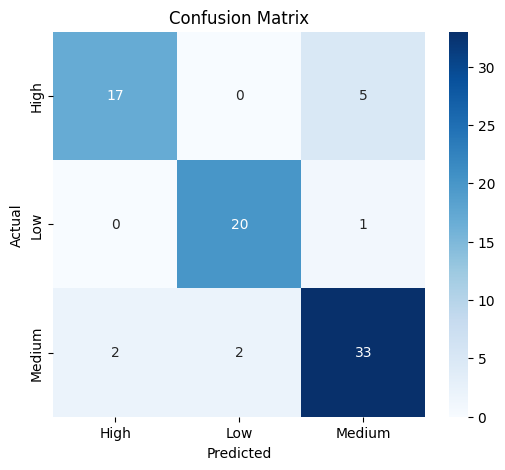

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Labels
labels = ['High', 'Low', 'Medium']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
